<a href="https://colab.research.google.com/github/salimsara/Projects/blob/main/BAY1_ProjectReport.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bayesian Inference 1: Project Report

### Title: Predicting flight delays

### Presented by: Sara Salim


## Abstract

> This project investigated the prediction of departure delays for flights operating at Pittsburgh International Airport (PIT) in 2006. The goal was to understand and predict delays exceeding 15 minutes based on flight attributes, like scheduled departure time and day of the week. A Bayesian probabilistic regression model was implemented, utilizing the probabilistic programming framework PyMC4. The model incorporated prior distributions for the regression coefficients and the variance of the delays, and posterior samples were generated with Markov Chain Monte Carlo (MCMC) sampling, furthermore using No-U-Turn Sampler (NUTS). The findings highlight a significant relationship between scheduled departure hour and small significance in day of the week with respect to delays. The results are further validated by plotting the trace of the sampling process and also evaluating posterior estimates. The approach provides some insights for airlines and airport management, but model needs further improvement before it can be used to optimize flight schedules.

## Introduction

The dataset in the file All_PIT_2006.csv is an extract from the Airline On-Time Performance Data made available through the Bureau of Transportation Statistics of the U.S. Department of Transportation. It contains flight activity to and from Pittsburgh International Airport (PIT) for the year 2006, specifically flights operated by U.S. certified air carriers contributing at least 1% of domestic passenger revenues. The variable to predict is "DepDelay", which is departure delay in minutes, and this project aims to consider delays exceeding 15 minutes, and utilize factors that influence delays. The hypothesis is that departure delays can be predicted using various flight attributes present in the data.

---

I'll be applying a Bayesian linear regression model to identify the most significant features for predicting flight delays. This model is particularly useful as it provides probabilistic estimates for each feature's contribution, capturing uncertainty in the predictions and helping us understand the impact of each factor, such as scheduled departure time and day of the week, on the likelihood of delays.

The implementation is done using Python, with libraries including Pandas, Numpy, Matplotlib, Seaborn, PyMC4, and ArviZ.

### Goals
* To identify features from the dataset that are useful in predicting flight delays
* To provide important insights for airlines and airport management to reduce delays
* To learn and gain experience with Bayesian inference, to use in real-world classification tasks

In [ ]:
!pip install pymc
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
!pip show pymc arviz
from IPython.display import Image

Name: pymc
Version: 5.19.1
Summary: Probabilistic Programming in Python: Bayesian Modeling and Probabilistic Machine Learning with PyTensor
Home-page: http://github.com/pymc-devs/pymc
Author: 
Author-email: 
License: Apache License, Version 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: arviz, cachetools, cloudpickle, numpy, pandas, pytensor, rich, scipy, threadpoolctl, typing-extensions
Required-by: 
---
Name: arviz
Version: 0.20.0
Summary: Exploratory analysis of Bayesian models
Home-page: http://github.com/arviz-devs/arviz
Author: ArviZ Developers
Author-email: 
License: Apache-2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: h5netcdf, matplotlib, numpy, packaging, pandas, scipy, setuptools, typing-extensions, xarray, xarray-einstats
Required-by: pymc


## Methods

*   Data preprocessing: Handling missing values, map the numerical values of weekdays into their actual names, excluding irrelevant and other delay-related columns, thresholding DepDelay to consider only delays over 15 minutes
*   Building the model: A Bayesian linear regression model is used to predict departure delays. The target variable is "DepDelay," and the predictors include "DayOfWeek" and "CRSDepHour."
*   Inference: The model parameters are estimated using Markov Chain Monte Carlo (MCMC) sampling, specifically the No-U-Turn Sampler (NUTS), a variant of Hamiltonian Monte Carlo that efficiently explores the posterior distribution.


### Dataset description and processing

There are a total of 57 variables/columns in the data. It includes temporal, operational, delay-related, and flight-specific attributes. The variables used in the model:

Random variables:
  - Target: DepDelay, that we aim to predict
  
Deterministic variables:
  - CRSDepTime
  - DayOfWeek

Distributions:
- DepDelay: Likely follows a skewed distribution
- DayOfWeek: Categorical distribution
- CRSDepTime: Gamma distribution

Variables used are CRSDepTime and DayOfWeek to provide information for departure delays.

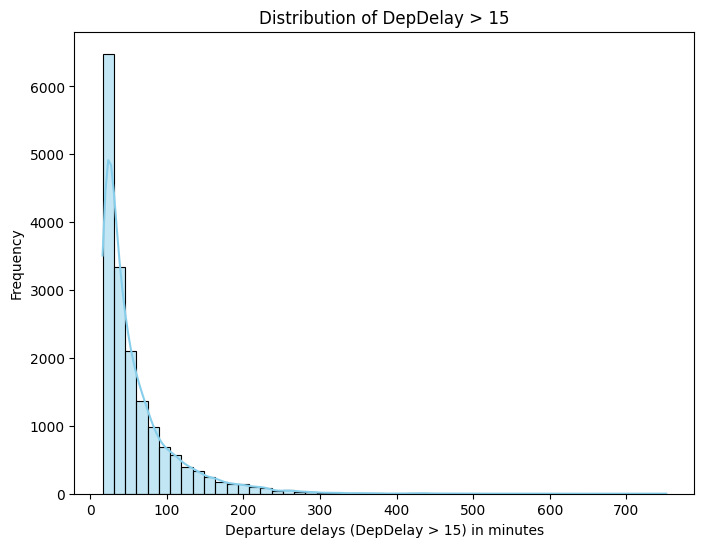

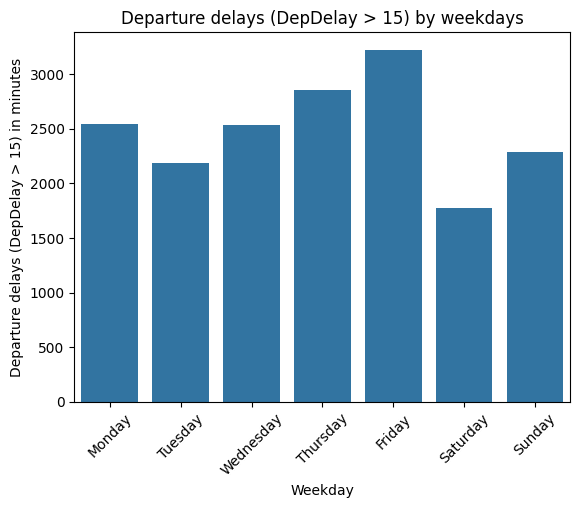

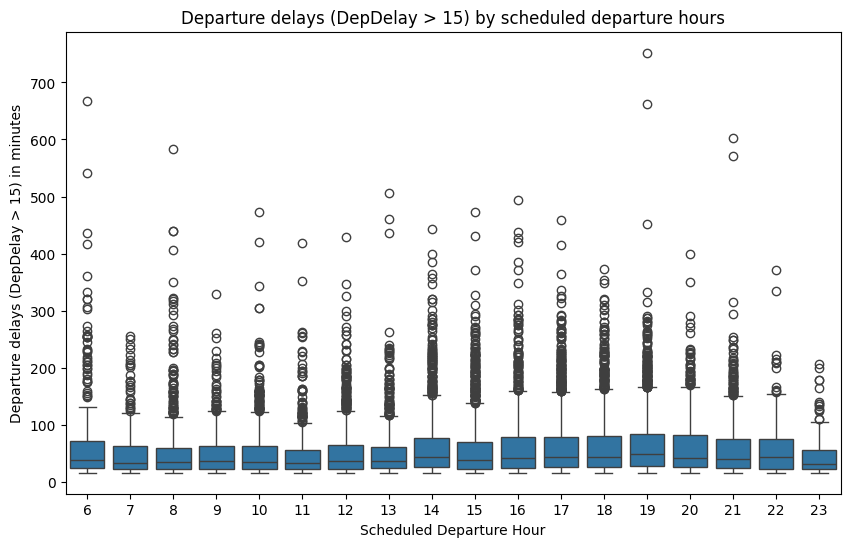

In [ ]:
# plot the variable distribution with some preprocessing here to
# support your assumption and hypothesis,  but don't be
# restricted to this code, you should think about relevant way
# of explaining your own hypothesis
# Load the dataset (replace with the actual path or URL if required)
data = pd.read_csv("/content/all_PIT_2006.csv")
# Excluding all indirectly delay-related and irrelevant columns
irrelevant = ['ArrDelay', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
              'SecurityDelay', 'LateAircraftDelay', 'DepDel15', 'DepDel30',
              'DepDelSys15','DepDelSys30','ArrDel15', 'ArrDel30', 'ArrDelSys15',
              'ArrDelSys30', 'ActualElapsedTime','CRSElapsedTime', 'AirTime',
              'TaxiIn', 'TaxiOut', 'WheelsOff', 'WheelsOn', 'Cancelled',
              'CancellationCode','Diverted','CRSArrTime','ArrTime','ArrTimeBlk',
              'ArrTimeBlk', 'Year', 'Quarter','Month','FlightDate','DayofMonth',
              'AirlineID', 'UniqueCarrier', 'FlightNum', 'TailNum', 'DepTime',
              'DepTimeBlk', 'DistanceGroup', 'Flights', 'OriginCityName',
              'OriginState', 'OriginStateFips', 'OriginStateName', 'OriginWac',
              'DestCityName', 'DestState', 'DestStateFips','DestStateName',
              'DestWac', 'Dest', 'Origin', 'Carrier', 'Distance']
data = data.drop(columns=irrelevant)
# Dropping rows with empty/missing values
data.dropna(inplace=True)
# Thresholding the delay to 15 mins
data = data[data['DepDelay'] > 15]
# Extracting the hours from scheduled departure times
data['CRSDepHour'] = (data['CRSDepTime'] // 100).astype(int)
# Giving weekday numbers actual names
weekday_map = {1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
               5: 'Friday', 6: 'Saturday', 7: 'Sunday'}
data['Weekday'] = data['DayOfWeek'].map(weekday_map)
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday',
                 'Saturday', 'Sunday']
data['Weekday'] = pd.Categorical(data['Weekday'], categories=weekday_order,
                                 ordered=True)

# Getting the independent variables
X1 = data['DayOfWeek']
X2 = data['CRSDepHour']
# Getting the target variable
y = data['DepDelay']

# 1. Distribution of DepDelay (Target variable)
plt.figure(figsize=(8, 6))
sns.histplot(y, bins=50, kde=True, color='skyblue')
plt.title("Distribution of DepDelay > 15")
plt.xlabel("Departure delays (DepDelay > 15) in minutes")
plt.ylabel("Frequency")
plt.show()
# Hypothesis: Distribution is right-skewed. Most delays cluster around smaller
# values, with a long tail for higher delays.

# 2. DepDelay vs Weekday
sns.countplot(x=data['Weekday'], data=data, order=weekday_order)
plt.title('Departure delays (DepDelay > 15) by weekdays')
plt.xlabel('Weekday')
plt.ylabel('Departure delays (DepDelay > 15) in minutes')
plt.xticks(rotation=45)
plt.show()
# Hypothesis: Weekends or specific weekdays might have higher average delays.

# 3. DepDelay vs Scheduled departure hour (CRSDepHour)
plt.figure(figsize=(10, 6))
sns.boxplot(x=X2, y=y, data=data)
plt.title('Departure delays (DepDelay > 15) by scheduled departure hours')
plt.xlabel('Scheduled Departure Hour')
plt.ylabel('Departure delays (DepDelay > 15) in minutes')
plt.xticks(range(18))
plt.show()
# Hypothesis: Peak travel hours could have more variability and higher delays.

### Model description

**Generative process:**

1. Generate for each day of the week:

- Draw from a categorical distribution:

      Weekday ~ Categorical(P1, P2,...P7,)
where pi represents the probability of each day (Monday to Sunday)

2. Generate scheduled departure time:

- Draw CRSDepTime from a Gamma distribution:
      CRSDepTime ~ Gamma(α, β)
where α and β are the shape and rate parameters of the gamma distribution, modeling the variability in scheduled departure times.

3. Generate departure delay:
Conditional on CRSDepTime and DayOfWeek, draw DepDelay from a skewed normal distribution
        DepDelay ~ SkewedNormal(μ, σ², λ)
      where:
  - Mean (μ) depends on CRSDepTime and DayOfWeek
  - Variance (σ²) captures spread
  - Skewness parameter (λ) adjusts for asymmetry

**Pseudo programme:**

1. Define the prior distribution for parameters:
Prior for delay mean (μ) and variance (σ²) based on initial knowledge.

    - μ_prior ~ Normal(0, 10)  <- Prior for the mean of the delay distribution
      
    - σ²_prior ~ InverseGamma(1, 1)  <- Prior for the variance of delay distribution

2. Define likelihood: Conditional distribution for delay (DepDelay) given features (X) and parameters (μ, σ²)

  for each flight in the dataset:
    - Collect features (X), such as day of the week, scheduled departure time, etc.
    - Predict delay (DepDelay) using a conditional normal distribution or another suitable model.
    
    - DepDelay | X ~ Normal(μ(X), σ²)
    - Here, μ(X) could depend on flight features (e.g., time of day, day of the week).
    - For simplicity, let's assume μ(X) is a linear function of the features.

3. Using Bayes' Theorem to compute the posterior distribution:
   P(μ, σ² | Data) ∝ P(Data | μ, σ²) * P(μ) * P(σ²)

    - Posterior(μ, σ² | Data) ∝ Likelihood(Data | μ, σ²) * Prior(μ) * Prior(σ²)

4. Use MCMC to sample from the posterior distribution:

  for each iteration:
    - Propose new values for μ and σ² based on prior and likelihood:
    μ_new, σ²_new = proposal(μ, σ²)
    - Calculate acceptance ratio (using posterior probabilities):
    acceptance_ratio = P(Data | μ_new, σ²_new) * P(μ_new) * P(σ²_new) / (P(Data | μ, σ²) * P(μ) * P(σ²))
    - Accept or reject the new samples:
    
            if accept(acceptance_ratio):
          
                μ = μ_new
        
                σ² = σ²_new

5. Predict flight delays based on posterior samples of μ and σ²

  for new_flight in new_data:
    
        μ_posterior_sample = sample_from(Posterior(μ | Data))
    
        σ²_posterior_sample = sample_from(Posterior(σ² | Data))

    Predict the delay based on the features of the new flight (X):
      
        Predicted_DepDelay = Normal(μ_posterior_sample(X), σ²_posterior_sample)

6. Threshold delays to only consider delays larger than 15 minutes
  
        if Predicted_DepDelay > 15:
    
    Output the predicted delay and associated features:
    
        output(Predicted_DepDelay, features_of_new_flight)

**Distributions and Parameters:**

1. Weekdays (DayOfWeek):
  - Distribution: Categorical(P1, P2,...P7,)
  - Parameters: Probabilities Pi for each day
2. Scheduled Departure Time (CRSDepTime):
  - Distribution: Gamma(α,β)
  - Parameters: Shape α, rate β
3. Departure Delay (DepDelay):
  - Distribution: SkewedNormal(μ, σ², λ)
  - Parameters:
    - Mean μ CRSDepTime and DayOfWeek.
    - Variance σ² is constant.
    - Skewness λ models asymmetry.

**Joint probability:**

P(DepDelay, CRSDepTime, DayOfWeek) = P(DepDelay | CRSDepTime, DayOfWeek)P(CRSDepTime)P(DayOfWeek)

**Graphical model:**

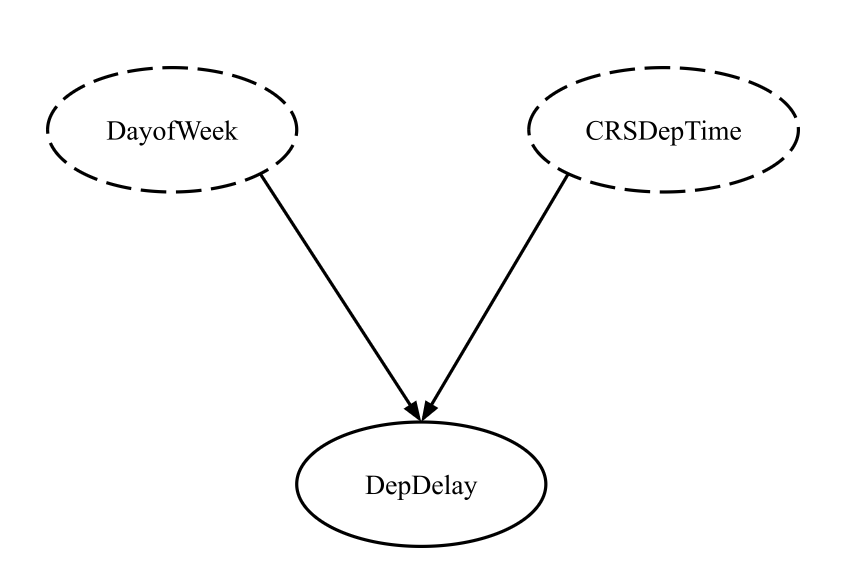

In [ ]:
Image(filename='/content/graphical_model.jpg', width=550, height=400)

### Inference Method

Computing the posterior distribution:

P(μ, σ² | Data) ∝ P(Data | μ, σ²)P(μ)P(σ²)

where:

- P(Data | μ, σ²) is the likelihood function (how likely is the data given the model parameters?)
- P(μ) and P(σ²) are the priors for the parameters μ (mean) and σ² (variance).

**Inference process steps:**

1. Specify the model:
  - Define the prior distributions for the parameter
  - Specify the likelihood of the data given the parameters
2. Sampling the posterior:
  - Using Markov Chain Monte Carlo (MCMC) methods like the No-U-Turn Sampler (NUTS) to sample from the posterior distribution
3. Posterior sampling:
  - Using the samples from the posterior distribution to make predictions or compute summaries of the model (such as the mean, variance, or credible intervals)

**Graph for inference model**

1. X1 (DayOfWeek) — observed variable, independent
2. X2 (CRSDepTime) — observed variable, independent
3. μ (mean delay) — latent variable, depends on DayOfWeek and CRSDepTime
4. y (DepDelay) - observed target variable that depends on μ and σ²
5. σ² (variance) — latent variable, treated as a hyperparameter, independent

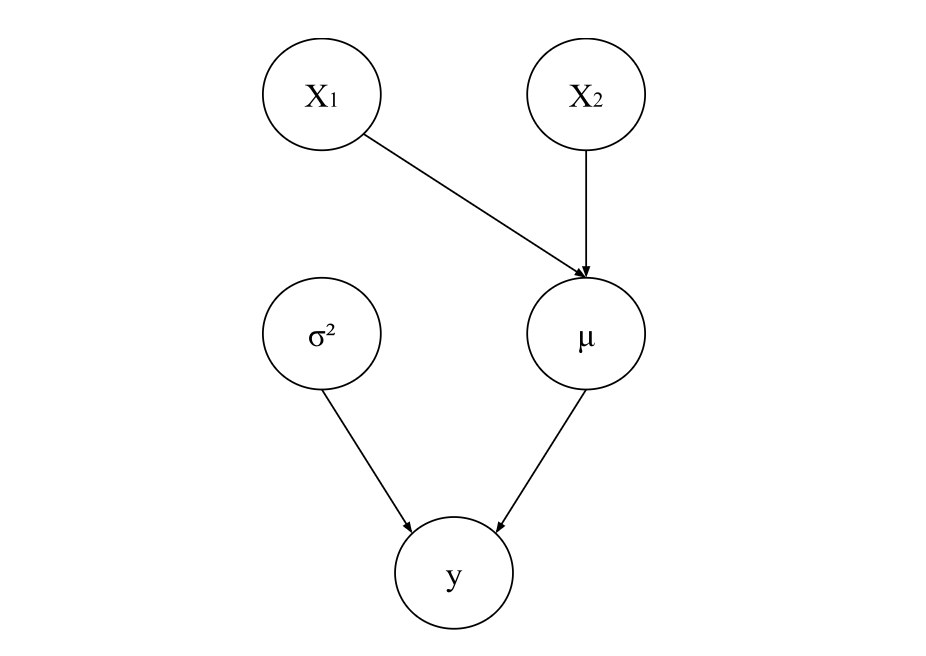

In [ ]:
Image(filename='/content/inference_model.jpg')

MCMC methods are used to sample from the posterior distribution, which includes both the latent variables (like μ and σ²) and model parameters (like β_1 and β_2). Specifically, the NUTS sampler is an efficient MCMC method to use for our model.

**Building the model:**

In [ ]:
# your code for building the model
# and doing the inference
X1 = data['DayOfWeek']
X2 = data['CRSDepHour']
y = data['DepDelay']

# Using PyMC4
with pm.Model() as model:
    # Priors for the regression coefficients
    beta_0 = pm.Normal("Intercept", mu=0, sigma=10)  # Intercept
    beta_1 = pm.Normal("DayOfWeek", mu=0, sigma=10)  # Day of week
    beta_2 = pm.Normal("CRSDepHour", mu=0, sigma=10)  # Scheduled departure hour

    # Prior for the standard deviation
    sigma = pm.HalfNormal("Std", sigma=10)

    # Linear model for the mean
    mu = beta_0 + beta_1 * X1 + beta_2 * X2

    # Likelihood (normal distribution for DepDelay)
    y_obs = pm.Normal("y_obs", mu=mu, sigma=sigma, observed=y)

    # Using NUTS sampler
    nuts = pm.NUTS()
    trace = pm.sample(1000, step=nuts, return_inferencedata=True)

Output()

Output()

## Experiment

Goal of this experiment is to evaluate the impact of DayOfWeek and CRSDepHour on departure delays and test the hypotheses derived from exploratory data analysis.

**Hypotheses:**

H₀: DayOfWeek or CRSDepHour do not significantly affect departure delays.

H₁: DayOfWeek or CRSDepHour have a significant effect on departure delays.

### Experiments setup

###(All preprocessing has been done in the "Methods" section)

### Results

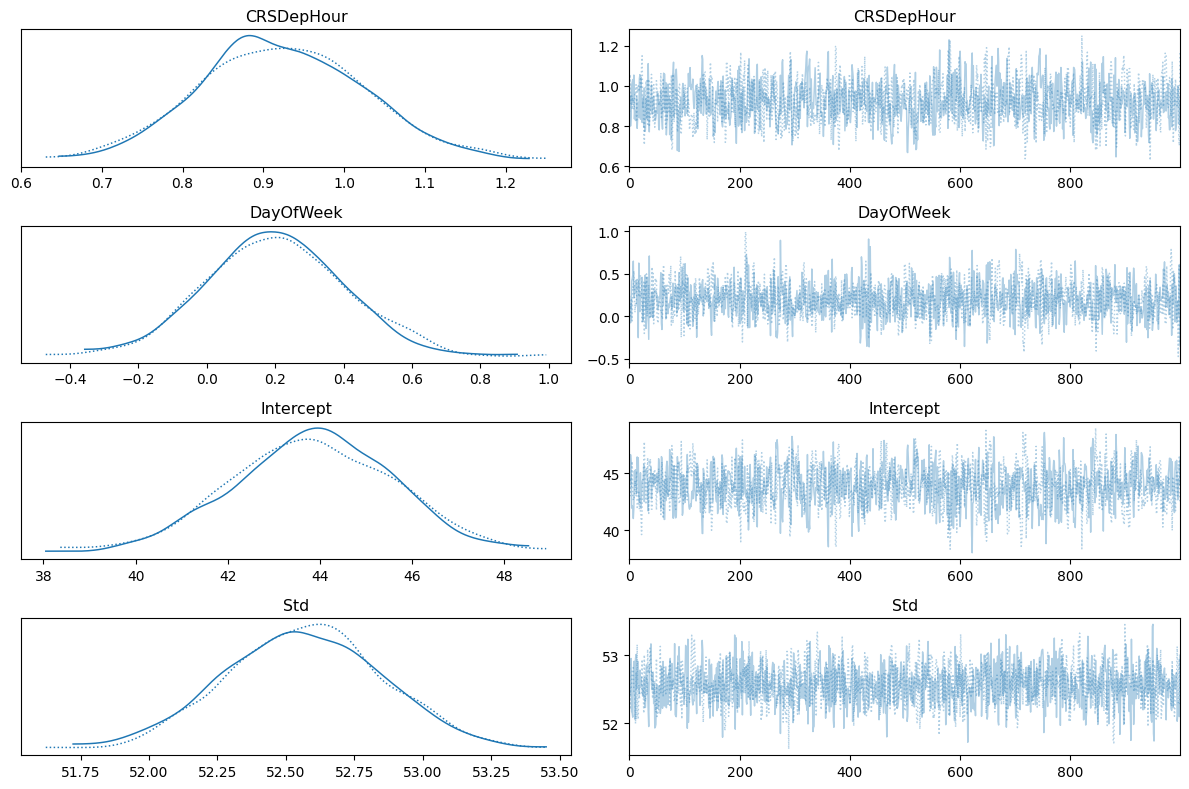

              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
CRSDepHour   0.924  0.101   0.732    1.111      0.003    0.002    1121.0   
DayOfWeek    0.201  0.203  -0.155    0.597      0.005    0.004    1564.0   
Intercept   43.837  1.756  40.495   47.043      0.055    0.039    1031.0   
Std         52.566  0.285  52.036   53.089      0.007    0.005    1719.0   

            ess_tail  r_hat  
CRSDepHour    1089.0    1.0  
DayOfWeek     1044.0    1.0  
Intercept     1110.0    1.0  
Std           1438.0    1.0  


In [ ]:
# Plotting trace of the sampling process
az.plot_trace(trace)
plt.tight_layout()
plt.show()

# Displaying the posterior summary
print(az.summary(trace))

**Interpretations:**

For CRSDepHour: The HDI (High Density Interval) for scheduled departure hours suggests that the true effect of scheduled departure time on departure delays is likely between 0.732 and 1.111 minutes. The interval does not include 0, which means that CRSDepHour is statistically significant in predicting delays. The mean value is 0.924, which indicates that each additional hour of scheduled departure is associated with a 0.924 minute increase in the departure delay, on average.

For DayOfWeek: The HDI for day of week is saying that the true effect is between -0.155 and 0.597, which means it includes 0. This indicates, that there is uncertainty about whether DayOfWeek has a statistically significant impact on departure delays. The mean is 0.201 which suggests that DayOfWeek is associated with a small increasing effect on departure delay.

For the intercept, which is departure delays alone, has a mean of 43.837 minutes, which is a big number, compared to the independent variables. The HDI indicates that the true baseline departure delay is likely between 40.495 and 47.043 minutes. It does not include 0, so this is a statistically significant delay.

The results suggest that even without accounting for DayOfWeek and CRSDepHour, there is already a significant departure delay expected. This is likely due to other factors, which were not studied in this model.

## Discussion and conclusion

In conclusion, the experiment demonstrated that departure delays at Pittsburgh International Airport can be predicted using flight attributes with reasonable accuracy. Although `DayOfWeek` didn't have a large significance in predicting the delays, tests show that `CRSDepTime` was found to have a significant importance. This means that the null hypothesis (H₀) of the experiment will be rejected. However, this model is not the best in providing accurate delay predictions. Future work could involve using more advanced models such as Random Forests or Neural Networks and expanding the model to include airports or other possible factors in the data, that could help predict the delays.